<a href="https://colab.research.google.com/github/kaleem500bc/Vanilla-A2C-CartPole/blob/main/Vanilla_A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
from torch import nn
import gym
from matplotlib import pyplot as plt
from collections import deque
import os
from torch.distributions import Categorical
from copy import deepcopy
import random
from IPython.display import clear_output
from IPython import display
from torch.utils.tensorboard import SummaryWriter


In [2]:

# make virtual screen and redirect render to this screen
# From https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!bash ../xvfb start
os.environ['DISPLAY'] = ':1'


Starting virtual X frame buffer: Xvfb.


In [3]:

class Actor(nn.Module):

  def __init__(self, states, actions):
    super().__init__()
    hidden = 128
    self.fc1 = nn.Linear(states,hidden)
    self.fc = nn.Linear(hidden, actions)
  
  def get_action_distribution(self,state):
    act = self.forward(state)
    act_probs = Categorical(logits=act)
    return act_probs

  def get_action(self,state):
    act_probs = self.get_action_distribution(state)
    return act_probs.sample().item()



  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.softmax(self.fc(x),dim = 0)
    return x

class Critic(nn.Module):
  
  def __init__(self,states):
    super().__init__()
    hidden = 128
    self.act_function = nn.LeakyReLU(0.1)
    self.fc1 = nn.Linear(states,hidden)
    self.fc = nn.Linear(hidden,1)
  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.act_function(self.fc(x))
    return x

# Holds the information about the episode 
class ReplayBuffer():
  def __init__(self):
    self.mem_size = 5000
    self.memory = deque(maxlen=self.mem_size)
    self.rewardsHistory = []
    self.statesHistory = []
    self.actionsHistory = []
    self.states_rewards_actions = []
  



In [4]:
# Create the environment
env = gym.make("CartPole-v0")
state = env.reset()
n_state = env.reset().shape[0]
n_action = env.action_space.n


In [26]:
# Create actor, critic and target critic model to stability
actor = Actor(n_state,n_action)
actor.to("cuda")
critic = Critic(n_state)
critic.to("cuda")
target_critic = Critic(n_state)
target_critic.load_state_dict(critic.state_dict())
target_critic.to("cuda")

Critic(
  (act_function): LeakyReLU(negative_slope=0.1)
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
# Used Adam optimizer
optim_actor = torch.optim.Adam(actor.parameters(), lr = 0.0001)
optim_critic = torch.optim.Adam(critic.parameters(), lr = 0.0001)

# Mean square loss function is used as objective function
criterion = nn.SmoothL1Loss()

In [28]:
# Populate the replay buffer with episodes
replay_buffer = ReplayBuffer()

def populate_buffer():
  state = env.reset()
  rewards = []
  states = [state]
  actions = []
  lmbda = 0.99
  for i in range(200):
    done = False
    while not done:
      act = actor.get_action(torch.tensor(state,dtype=torch.float,device="cuda"))

      next_state, reward, done, _ = env.step(act)
      reward = reward if not done else -20        

      rewards.append(reward)
      states.append(next_state)
      actions.append(act)
      state = next_state
    
    discounted_rewards = []
    for i in range(len(rewards)):
      t = [(lmbda**j)*r for j,r in enumerate(rewards[i:i+5])]
      discounted_rewards.append(t)

    replay_buffer.statesHistory.append(states)
    replay_buffer.rewardsHistory.append(discounted_rewards)
    replay_buffer.actionsHistory.append(actions)
    for i,(state,act,reward) in enumerate(zip(states[:-1], actions, discounted_rewards)):
      if i+5 >= len(states):
        n_state = states[len(states)-1]
        lmbda_power = -1
      else:
        n_state = states[i+5]
        lmbda_power = 5
      replay_buffer.memory.append((state,act,sum(reward),n_state,lmbda_power))

    actions = []
    rewards = []
    state = env.reset()
    states = [state]


populate_buffer()



In [29]:
a_loss, c_loss = [],[]

In [30]:


def training_One_step_TD(batch_size,epoch,target_critic,target_actor,critic,actor, optim_actor, optim_critic):

  update_target = 0

  # Discount
  lmbda = 0.99
  for e in range(epoch):
    critic_loss_per_epoch = 0
    actor_loss_per_epoch = 0
    for b in range(len(replay_buffer.memory)//batch_size):
      batch = random.sample(replay_buffer.memory, batch_size)
      batch_critic_loss = 0
      batch_actor_loss = 0
      for state,act,reward,n_state,l_power in batch:

        predicted_reward = critic(torch.tensor(state,dtype=torch.float,device="cuda"))
        # Actor loss
        if l_power != -1:
          expected_reward = torch.tensor(reward, dtype = torch.float, device = "cuda").view(1) + (lmbda ** l_power) * target_critic(torch.tensor(n_state,dtype=torch.float,device="cuda")).detach()
        else:
          expected_reward = torch.tensor(reward, dtype = torch.float, device = "cuda").view(1)
        adv = expected_reward - predicted_reward.clone().detach().requires_grad_(True)
        act_distribution = actor.get_action_distribution(torch.tensor(state,dtype=torch.float,device="cuda"))
        actor_probs = act_distribution.log_prob(torch.tensor(act,device="cuda"))
        batch_actor_loss -=  actor_probs * adv

        # critic loss 
        batch_critic_loss +=  criterion(predicted_reward,expected_reward)

      
      # Update actor model parameters

      optim_actor.zero_grad()
      batch_actor_loss.backward()
      optim_actor.step()

      # Update critic model parameters
      optim_critic.zero_grad()
      batch_critic_loss.backward()
      optim_critic.step()

      
      if (update_target >= 30):
        temp = critic.state_dict()
        critic.load_state_dict(target_critic.state_dict())
        target_critic.load_state_dict(temp)

        # temp = actor.state_dict()
        # actor.load_state_dict(target_actor.state_dict())
        # target_actor.load_state_dict(temp)

        update_target = 0

      update_target += 1

      critic_loss_per_epoch += batch_critic_loss.item()
      actor_loss_per_epoch += batch_actor_loss.item()


      

     




    a_loss.append(actor_loss_per_epoch)
    c_loss.append(critic_loss_per_epoch)
      # print("Critic Loss: ",critic_loss_per_epoch)
      # print("Actor Loss: ",actor_loss_per_epoch)
    # After each batch size update the target network
    print(e)
  return a_loss,c_loss




In [ ]:
actor_loss, critic_loss = training_One_step_TD(10,30,target_critic,target_actor,critic,actor, optim_actor, optim_critic)

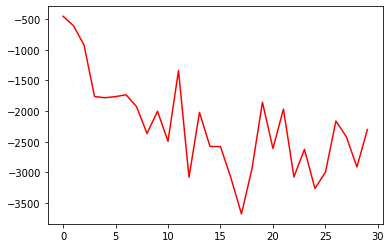

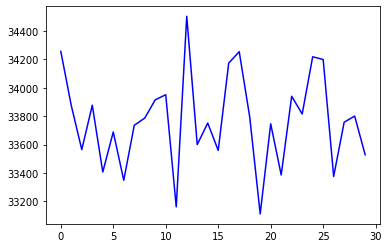

In [32]:
plt.plot(actor_loss,label="actor",color="red")
plt.show()
plt.plot(critic_loss,label="critic",color="blue")

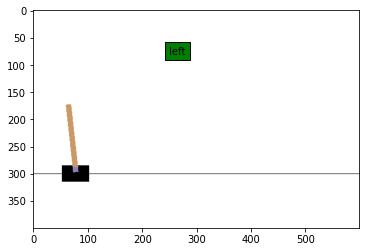

score:  200


In [35]:

state = env.reset()
done = False
display_img = plt.imshow(env.render("rgb_array"))
i = 0
act_seq = []
# for j in range(100):
#   state = env.reset()
#   done = False
while not done:
  state = torch.tensor(state,dtype=torch.float,device="cuda")
  act = torch.argmax(actor(torch.tensor(state,dtype=torch.float,device="cuda")))
  state, reward, done, _ = env.step(act.item())
  if act == 0:
    action_text = "left"
    bbox_color = "green"
  else:
    action_text = "right"
    bbox_color = "red"
  plot_action_text = plt.text(250,80,action_text,bbox=dict(facecolor=bbox_color))

  display_img.set_data(env.render("rgb_array"))
  clear_output(wait=True)
  display.display(plt.gcf())
  i += 1
  plot_action_text.remove()



print("score: ",i)